🔍 DEBUG suggest_all_params - Parámetros generados:
🔍   CatBoost params: ['cat_main_iterations', 'cat_main_depth', 'cat_main_learning_rate', 'cat_main_l2_leaf_reg', 'cat_main_early_stopping', 'cat_meta_iterations', 'cat_meta_depth', 'cat_meta_learning_rate', 'cat_meta_l2_leaf_reg', 'cat_meta_early_stopping']
🔍   Feature params: ['feature_main_periods', 'feature_main_stats', 'feature_meta_periods', 'feature_meta_stats']
🔍   Label params: ['label_markup', 'label_min_val', 'label_max_val', 'label_atr_period', 'label_method_random']
🔍   Algo params: ['cluster_lgmm_components', 'cluster_lgmm_covariance', 'cluster_lgmm_iter', 'meta_threshold', 'main_threshold']
🔍   Total params: 24
🔍 DEBUG search_clusters lgmm - Parámetros clusters: {'cluster_lgmm_components': 3, 'cluster_lgmm_covariance': 'diag', 'cluster_lgmm_iter': 193}
🔍 DEBUG: base_df.shape = (32877, 5)
🔍 DEBUG: train_start = 2020-02-01 00:00:00, train_end = 2025-02-01 00:00:00
🔍 DEBUG: test_start = 2022-02-01 00:00:00, test_end = 2023-0

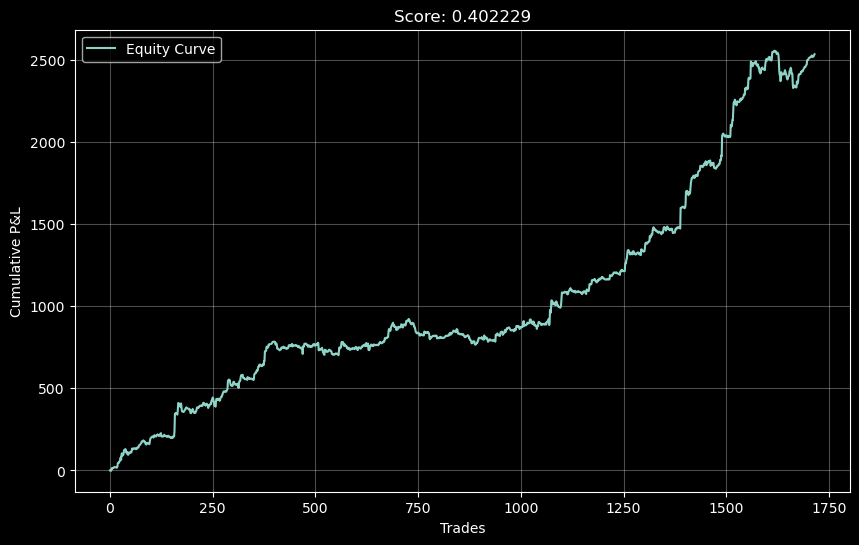

🔍 DEBUG: Tiempo de test in-sample: 1.99 segundos
🔍 DEBUG: Score in-sample: 0.4022285891344464
🔍   DEBUG: Dataset con shape (29580, 47) guardado en /tmp/tmpiraj_3tu.csv
🔍      labels_main value_counts: {0.4790618419647217: 1065, 0.47752058506011963: 322, 0.48035162687301636: 144, 0.48301786184310913: 143, 0.4801099896430969: 116, 0.479200541973114: 80, 0.4827330708503723: 76, 0.48167914152145386: 64, 0.4998258352279663: 52, 0.4803122878074646: 45, 0.4818814992904663: 39, 0.47588837146759033: 39, 0.478568434715271: 35, 0.5013970136642456: 31, 0.4792640805244446: 31, 0.483156681060791: 31, 0.4766097068786621: 28, 0.4959278106689453: 27, 0.48323601484298706: 26, 0.4924613833427429: 24, 0.4843083620071411: 24, 0.48052626848220825: 24, 0.4847880005836487: 23, 0.49987488985061646: 22, 0.4950982928276062: 21, 0.48423296213150024: 20, 0.4739093780517578: 20, 0.4987432360649109: 19, 0.47847527265548706: 19, 0.4795093536376953: 19, 0.49854594469070435: 19, 0.4749109148979187: 17, 0.50111770629882

In [1]:
import optuna
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed
from modules.StrategySearcher import StrategySearcher
import warnings
import os
warnings.filterwarnings("ignore")

configs = [
    dict(
        symbol='XAUUSD', timeframe='H1', direction='buy', pruner_type='successive',
        train_start=datetime(2020,2,1), train_end=datetime(2025,2,1),
        test_start=datetime(2022,2,1),  test_end=datetime(2023,2,1),
        search_type='clusters', search_subtype='lgmm', search_filter='',
        label_method='random', n_models=1, debug=True,
    ),
]

# Crear tag para cada configuración
for cfg in configs:
    # Construir el tag asegurando que no haya dobles guiones bajos por campos vacíos
    tag_parts = [
        cfg['symbol'],
        cfg['timeframe'],
        cfg['direction'],
        cfg['label_method'][:2],
        cfg['search_type'][:3],
        (cfg.get('search_subtype') or '')[:2],
        (cfg.get('search_filter') or '')[:2],
    ]
    # Filtrar partes vacías y unir con "_"
    cfg["tag"] = "_".join([part for part in tag_parts if part]).strip("_")

DB_FILE = f"optuna_dbs/{cfg['tag']}.db"
DB_PATH = f"sqlite:///{DB_FILE}"
STUDY_NAME = f"{cfg['tag']}"

study = None
if not os.path.exists(DB_FILE):
    study = None
else:
    try:
        study = optuna.load_study(study_name=STUDY_NAME, storage=DB_PATH)
    except Exception:
        study = None

n_trials = 5000
if study:
    n_trials = len(study.trials) + n_trials

for cfg in configs:
    cfg['n_trials'] = n_trials

def launch(cfg):
    s = StrategySearcher(**cfg)
    s.run_search()

with ProcessPoolExecutor(max_workers=len(configs)) as pool:
    futures = {pool.submit(launch, c): c["tag"] for c in configs}
    for f in as_completed(futures):
        tag = futures[f]
        try:
            print(f"[{tag}] terminado")
        except Exception as e:
            print(f"[{tag}] falló: {e}")